C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


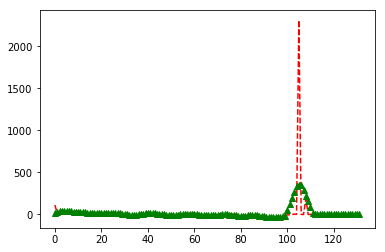

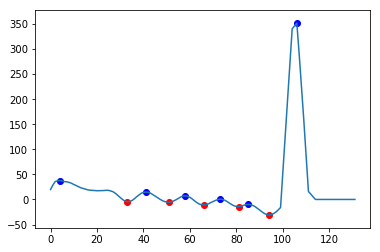

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:168: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import math as m
import csv
from numpy import linspace, loadtxt, ones, convolve, NaN, Inf, arange, isscalar, asarray, array
from __future__ import division

#Moving Mean
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

#Peak detect
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#trial = "9"
path = "C:\\Users\\Shradha Shalini\\Documents\\PT_Data_Collection\\Subject_test\\091317\\26_FourMeterWalkStandStill\\4"
#path = "C:\\Users\\Shradha Shalini\\Documents\\Kinect2Sample-master\\sample\\build2\\Depth\\"+trial
#C:\Users\Shradha Shalini\Documents\Kinect2Sample-master\sample\build2\Depth\9


#Get and process centroid
centroid_data=pd.read_csv(path+"\\centroids.csv")
centroids = centroid_data;
centroids.columns = ['x','y','z']

#plt.plot(centroids['z'], centroids['x'])
#plt.show()

#Get and process time
centroid_time=pd.read_csv(path+"\\centroids_time.csv")
centroid_time.columns = ['hour','min','sec','milis']
##Get the time series time data
time=[]
for i in range(len(centroids['x'])):
    time.append((centroid_time.ix[i,'min'])*60+(centroid_time.ix[i,'sec'])+centroid_time.ix[i,'milis']*0.001)
time= time-time[0]

#Get all foot prints
F=[]
for i in range(len(centroids['x'])):
    string=path
    string+="\\"+str(i+1)+".csv"
    F.append(pd.read_csv(string, skiprows=[0]))
    

corr=[]
for i in range(0, len(centroids['x']), 1):
    ##Convert to inches
    steps =F[i]*39.3701;
    steps.columns=['x','y','z']
    steps['z']= steps['z']*-1
    
    ##Find Mean of data
    steps['x']=steps['x']-steps['x'].mean()
    steps['z']=steps['z']-steps['z'].mean()
    Foot = steps[['x','z']]

    
    newArray = pd.DataFrame([[0, 0]], columns=list('xz'))
    counter=0;

    newArray= Foot.loc[abs(Foot['x'])<25,:]
                
    newArray['x']=newArray['x']-newArray['x'].mean()
    newArray['z']=newArray['z']-newArray['z'].mean()

    ##Find correlation
    M = newArray['x']*newArray['z']
    try:
        corr.append(sum(M)/len(newArray)) 
    except ZeroDivisionError:
        corr.append(0) 
    
corr_av= movingaverage(corr, 7)
corr_av= movingaverage(corr_av, 5)
plt.plot(corr,'r--',corr_av,'g^')
plt.show()

maxtab_wt, mintab_wt = peakdet(corr_av,1)
plt.plot(corr_av)
plt.scatter(array(maxtab_wt)[:,0], array(maxtab_wt)[:,1], color='blue')
plt.scatter(array(mintab_wt)[:,0], array(mintab_wt)[:,1], color='red')
plt.show()

#Start end frames for time
if(maxtab_wt[0][0]<mintab_wt[0][0]):
    time_start=maxtab_wt[0][0];
else:
    time_start=mintab_wt[0][0];
    
if(maxtab_wt[len(maxtab_wt)-1][0]>mintab_wt[len(mintab_wt)-1][0]):
    time_end=maxtab_wt[len(maxtab_wt)-1][0];
else:
    time_end=mintab_wt[len(mintab_wt)-1][0];
    
time_walk= time[time_start:time_end];


#For number of steps see if the first point is a hight point or last point a high point. They should not be considered.
noSteps = 0
if maxtab_wt[0][0]==0.0:
    noSteps += 1
if mintab_wt[-1][0]==len(corr_av):
    noSteps += 1
    
timeOfCompletion = time_walk[len(time_walk)-1]-time_walk[0]
numberOfSteps = len(maxtab_wt)+len(mintab_wt)-noSteps
gait_speed = 4.0/timeOfCompletion
avg_step_length = 4.0/numberOfSteps
cadance = numberOfSteps/4

#output
with open('FourMWalkResultsPython.csv', 'w') as csvfile:
    fieldnames = ['timeOfCompletion(s)', 'numberOfSteps','gait_speed(m/s)','avg_step_length(m)','cadance']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerow({ 'timeOfCompletion(s)': timeOfCompletion, 'numberOfSteps':numberOfSteps, 'gait_speed(m/s)': gait_speed, 'avg_step_length(m)':avg_step_length, 'cadance':cadance})



In [25]:
centroids

,x,y,z
0,1.063630,1.253380,6.02579
1,1.070280,1.252970,6.03108
2,1.061210,1.233520,5.97710
3,1.061750,1.214050,5.95879
4,1.058360,1.211050,5.94384
5,1.040120,1.160570,5.87810
6,1.034190,1.189000,5.84398
7,1.014940,1.138430,5.78122
8,1.007480,1.124310,5.75632
9,0.993828,1.119700,5.70319


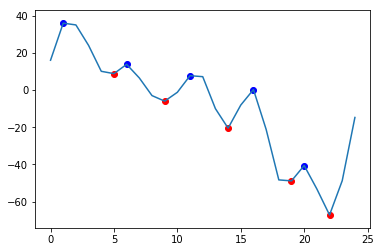

In [415]:
maxtab_wt, mintab_wt = peakdet(corr_av,1)
plt.plot(corr_av)
plt.scatter(array(maxtab_wt)[:,0], array(maxtab_wt)[:,1], color='blue')
plt.scatter(array(mintab_wt)[:,0], array(mintab_wt)[:,1], color='red')
plt.show()

In [416]:
#Start end frames for time
if(maxtab_wt[0][0]<mintab_wt[0][0]):
    time_start=maxtab_wt[0][0];
else:
    time_start=mintab_wt[0][0];
    
if(maxtab_wt[len(maxtab_wt)-1][0]>mintab_wt[len(mintab_wt)-1][0]):
    time_end=maxtab_wt[len(maxtab_wt)-1][0];
else:
    time_end=mintab_wt[len(mintab_wt)-1][0];
    
time_walk= time[time_start:time_end];

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [417]:
time_walk

array([ 0.199,  0.4  ,  0.575,  0.806,  1.016,  1.221,  1.412,  1.605,
        1.797,  1.989,  2.198,  2.464,  2.742,  2.984,  3.248,  3.481,
        3.713,  3.958,  4.202,  4.471,  4.751])

In [424]:
timeOfCompletion = time_walk[len(time_walk)-1]-time_walk[0]
numberOfSteps = len(maxtab_wt)+len(mintab_wt)
gait_speed = 4.0/timeOfCompletion
avg_step_length = 4.0/numberOfSteps
cadance = numberOfSteps/4

#output
with open('FourMWalkResultsPython.csv', 'w') as csvfile:
    fieldnames = ['timeOfCompletion(s)', 'numberOfSteps','gait_speed(m/s)','avg_step_length(m)','cadance']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerow({ 'timeOfCompletion(s)': timeOfCompletion, 'numberOfSteps':numberOfSteps, 'gait_speed(m/s)': gait_speed, 'avg_step_length(m)':avg_step_length, 'cadance':cadance})



In [419]:
timeOfCompletion


4.5520000000000209

In [420]:
numberOfSteps


10

In [421]:
gait_speed


0.87873462214410847

In [422]:
avg_step_length


0.4

In [423]:
cadance

2

In [ ]:
#Get ready to calculate coorelations:
corr=[]
for i in range(len(centroids['x'])):
    data = F[i]
    x = pd.to_numeric(data["x"])
    y = pd.to_numeric(data["z"])
    x_1 = []
    y_1 = []
    x_mean = x.mean()
    x_stdev = x.std()
    y_mean = y.mean()
    y_stdev = y.std()
    
    x = x - x_mean
    y = y - y_mean
    
    x_mean = x.mean()
    x_stdev = x.std()
    y_mean = y.mean()
    y_stdev = y.std()
    
    for j in range(len(x)):
        if(abs(y[j]-y_mean)<2*y_stdev and abs(x[j]-x_mean)<2*x_stdev):
            x_1.append(x[j])
            y_1.append(y[j])
            counter = counter +1
    
    plt.scatter(x_1,y_1)
    plt.show()      
    
    ##Find correlation
    x_1 = np.asarray(x_1)
    y_1 = np.asarray(y_1)
    M = x_1*y_1
    corr.append(sum(M)/len(newArray)) 

corr_av= movingaverage(corr, 5)
plt.plot(corr_av)
plt.show()

# 4 meter only code

In [ ]:
#Consider2-5 meters

#Get and process centroid
centroid_data=pd.read_csv(path+"\\centroids.csv")
centroids = centroid_data;
centroids.columns = ['x','y','z']


plt.plot(centroids['z'], centroids['x'])
plt.show()

#Get and process time
centroid_time=pd.read_csv(path+"\\centroids_time.csv")
centroid_time.columns = ['hour','min','sec','milis']
##Get the time series time data
time=[]
for i in range(len(centroids['x'])):
    time.append((centroid_time.ix[i,'min'])*60+(centroid_time.ix[i,'sec'])+centroid_time.ix[i,'milis']*0.001)
time= time-time[0]

#Get all foot prints
F=[]
for i in range(len(centroids['x'])):
    string=path
    string+="\\"+str(i+1)+".csv"
    F.append(pd.read_csv(string, skiprows=[0]))

In [54]:
fm_centroids = centroids.loc[(centroids['z'] <= '6') & (centroids['z'] >= '1.8')]

In [57]:
centroid_time.loc[(centroids['z'] <= '6') & (centroids['z'] >= '1.8')]

,hour,min,sec,milis
9,5,43,48,501
10,5,43,48,577
11,5,43,48,662
12,5,43,48,712
13,5,43,48,796
14,5,43,48,861
15,5,43,48,918
16,5,43,48,979
17,5,43,49,46
18,5,43,49,99


In [63]:
time

array([ 0.   ,  0.065,  0.123,  0.176,  0.24 ,  0.339,  0.428,  0.49 ,
        0.552,  0.62 ,  0.696,  0.781,  0.831,  0.915,  0.98 ,  1.037,
        1.098,  1.165,  1.218,  1.283,  1.348,  1.415,  1.474,  1.537,
        1.597,  1.657,  1.719,  1.786,  1.855,  1.906,  1.969,  2.031,
        2.095,  2.159,  2.227,  2.29 ,  2.35 ,  2.41 ,  2.455,  2.517,
        2.595,  2.66 ,  2.723,  2.791,  2.86 ,  2.926,  2.989,  3.048,
        3.115,  3.178,  3.26 ,  3.33 ,  3.395,  3.459,  3.536,  3.596,
        3.66 ,  3.731,  3.798,  3.862,  3.937,  4.003,  4.066,  4.143,
        4.224,  4.304,  4.364,  4.437,  4.503,  4.583,  4.659,  4.727,
        4.803,  4.864,  4.925,  4.997,  5.089,  5.161,  5.236,  5.322,
        5.414,  5.488,  5.565,  5.655,  5.737,  5.826,  5.926,  6.026,
        6.129,  6.226,  6.318,  6.413,  6.504,  6.622,  6.691,  6.763,
        6.827,  6.905,  6.995,  7.101,  7.192,  7.263,  7.36 ,  7.454,
        7.551,  7.596,  7.649,  7.726,  7.762,  7.819,  7.863,  7.928,
      

In [59]:
F.loc[(centroids['z'] <= '6') & (centroids['z'] >= '1.8')]

AttributeError: 'list' object has no attribute 'loc'

In [61]:
for i in fm_centroids.index:
    print i

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
129


In [62]:
centroids

,x,y,z
0,-0.825263,0.995031,6.32358
1,-0.819656,0.983501,6.28025
2,-0.81339,0.99024,6.25368
3,-0.809633,0.946876,6.23271
4,-0.802106,0.93508,6.19238
5,-0.789363,0.901255,6.12884
6,-0.775096,0.878935,6.0773
7,-0.774433,0.871163,6.06368
8,-0.761172,0.867316,6.01283
9,-0.743308,0.868688,5.95664
